In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 16,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'legend.fontsize': 16,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [3]:
#Data from vizier without treatment
raw_dataVIS = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_dataVIS['Wave A'] = (10**(8))/raw_dataVIS['Wave (cm)']

#Invert the values for the index in python
raw_dataVIS = raw_dataVIS.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

In [4]:
raw_dataNIR = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_dataNIR['Wave A'] = (10**(8))/raw_dataNIR['Wave (cm)']

#Invert the values for the index in python
raw_dataNIR = raw_dataNIR.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

In [5]:
#Lines from the file of Clean lines
raw_lambdaVIS = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\Nave Fe I list_VIS.xlsx", skiprows=10, usecols=[0], names=['Nave list'])

In [6]:
#Lines from the file of Clean lines
raw_lambdaNIR = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\Nave Fe I_NIR.xlsx", skiprows=10, usecols=[0], names=['Nave list'])

In [7]:
raw_data = pd.concat([raw_dataVIS,raw_dataNIR],axis=0).drop_duplicates('Wave A',keep='first').reset_index(drop=True) 

In [8]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)

In [9]:
closer_lines_VIS = find_minimums(raw_dataVIS['Wave A'],raw_dataVIS['nFlux'],raw_lambdaVIS['Nave list'])

In [10]:
closer_lines_NIR = find_minimums(raw_dataNIR['Wave A'],raw_dataNIR['nFlux'],raw_lambdaNIR['Nave list'])

In [11]:
closer_lines = pd.concat([closer_lines_VIS,closer_lines_NIR],axis=0).drop_duplicates('Fe line',keep='first').reset_index(drop=True) 

In [12]:
closer_lines_VIS = closer_lines[closer_lines['Fe line'].between(4000,7960,inclusive='right')]
closer_lines_NIR = closer_lines[closer_lines['Fe line'].between(7960,23000,inclusive='right')]

raw_data_VIS = raw_data[raw_data['Wave A'].between(4000,7960,inclusive='right')]
raw_data_NIR = raw_data[raw_data['Wave A'].between(7960,23000,inclusive='right')]

In [13]:
#Separate by minimum wavelength and ranges for windows
def width_minimums(closer_lines,data,steps):
    local_points =[]
    steps_final = []
    for each in closer_lines['min_wave']:
        window = []
        step_accepted = []
        for step in steps:
            #This generates a list with dataframes representing each step taken
            new_data = data[data['Wave A'].between(each-(step/2), each+(step/2), inclusive='neither')]
            if len(new_data)>0:
                window.append(new_data)
                step_accepted.append(step)

        local_points.append(window) #Add the list representing one closer line
        steps_final.append(step_accepted)
    return local_points ,steps_final

In [14]:
steps = np.arange(0.02,0.2,0.005)
local_points_VIS,steps_final = width_minimums(closer_lines_VIS,raw_data_VIS,steps)

In [15]:
def Fit_derivates(local_points,wave,steps):
    values = []
    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/wave) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            values.append(pd.DataFrame([[wave,lamda_obs[0],lamda_obs[1],velocity,blueshift,1-lamda_obs[1],round(steps[i],3)]])) 


    Values =  pd.concat(values,axis=0).reset_index(drop=True)
    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Blueshift",'Line Depth','Window (A)']
    variance = np.var(Values['Observed wavelength'])
    deviation = np.std(Values['Observed wavelength'])

    return Values, variance, deviation

In [16]:
len(local_points_VIS)

513

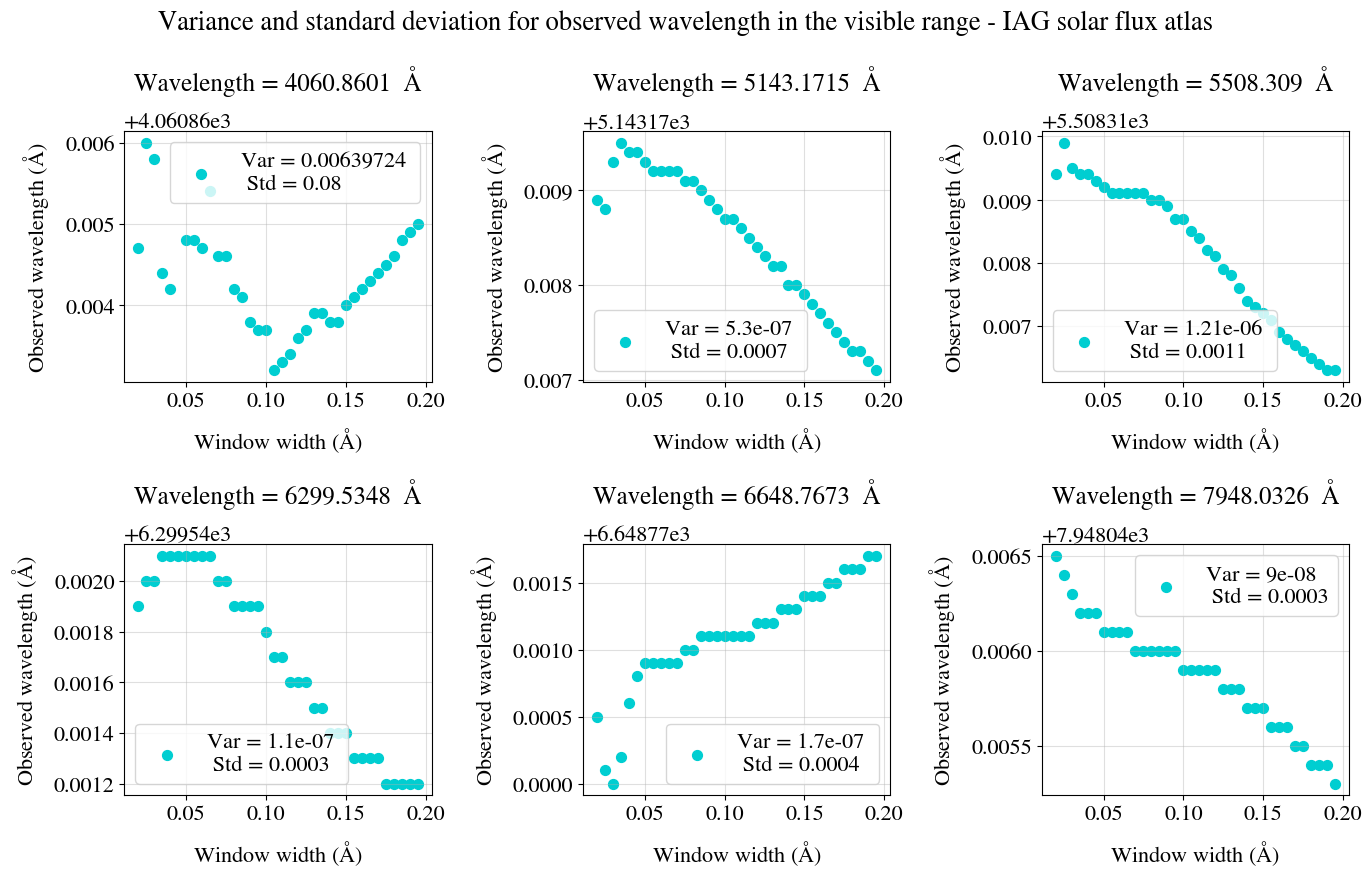

In [17]:
list_index = [0,172,235,378,420,510]

fig5, axes = plt.subplots(2,3,figsize=(14,9))
fig5.suptitle('Variance and standard deviation for observed wavelength in the visible range - IAG solar flux atlas')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
    Values,variance, deviation = Fit_derivates(local_points_VIS[list_index[i]],closer_lines_VIS['Fe line'].iloc[list_index[i]],steps_final[i])
    Values = Values[Values['Velocity'].between(-700,700)]

    ax.scatter(Values['Window (A)'],Values["Observed wavelength"],label = 'Var = {} \n Std = {}'.format(round(variance,8),round(deviation,4)),c='darkturquoise',s=50) 

    ax.set_title(r'Wavelength = {}  Å'.format(Values["Emitted wavelength"].iloc[0]),pad=30)   
    ax.set_ylabel(r'Observed wavelength $(\mathrm{\AA})$',labelpad=10)
    ax.set_xlabel(r'Window width $(\mathrm{\AA})$',labelpad=10)
    ax.grid(alpha=0.4)
    ax.legend()

fig5.tight_layout()
# fig5.savefig('variance std VIS')

In [18]:
#We selected bins for the width to see the slope for a lineal fit
Big_Data_VIS = []

for i in range(len(closer_lines_VIS)):
    Values,_,_ = Fit_derivates(local_points_VIS[i],closer_lines_VIS['Fe line'].iloc[i],steps_final[i])
    Big_Data_VIS.append(Values)

Data_VIS = pd.concat(Big_Data_VIS,axis=0)

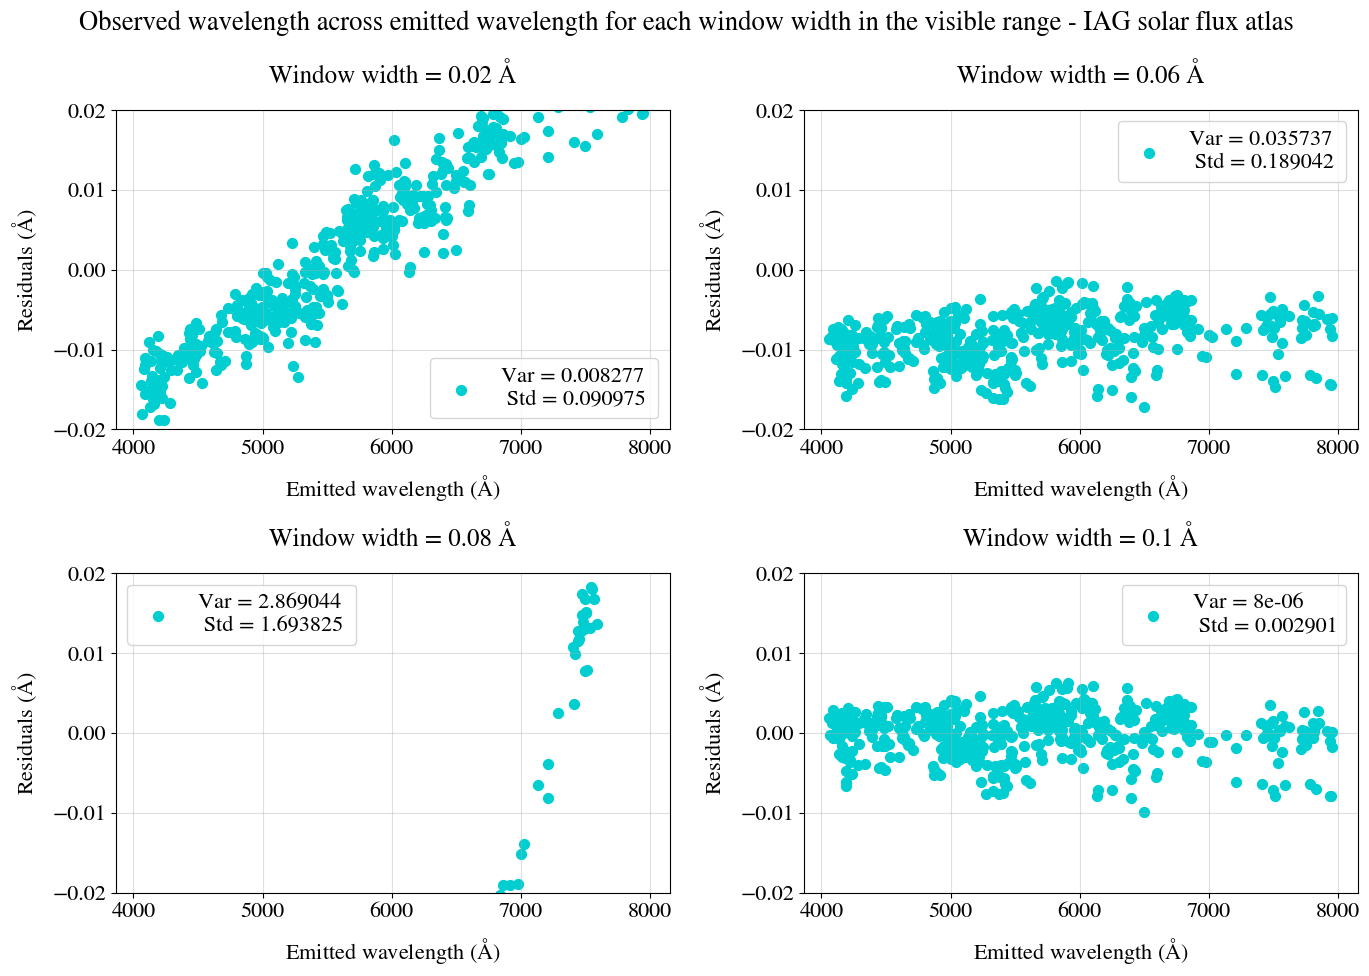

In [19]:
list_index = [0,8,12,16]
steps = np.arange(0.02,0.2,0.005)

fig5, axes = plt.subplots(2,2,figsize=(14,10))
fig5.suptitle('Observed wavelength across emitted wavelength for each window width in the visible range - IAG solar flux atlas')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
    new_data = Data_VIS[Data_VIS['Window (A)']==round(steps[list_index[i]],3)].sort_values(by='Emitted wavelength',ascending=True).reset_index(drop=True)
    
    #Data parameters
    if len(new_data)>0:
        param, cov = np.polyfit(new_data['Emitted wavelength'],new_data['Observed wavelength'], 1,cov=True)
        fit = np.polyval(param,new_data['Emitted wavelength'])
        error = np.sqrt(np.diag(cov))

        residuals = fit-new_data['Observed wavelength'] 
        ax.scatter(new_data['Emitted wavelength'],residuals,c='darkturquoise',s=50,label='Var = {} \n Std = {}'.format(round(np.var(residuals),6),round(np.std(residuals),6))) 
        ax.set_ylim(-0.020,0.020)

    ax.set_title('Window width = {} Å'.format(round(steps[list_index[i]],4)),pad=20)   
    ax.set_ylabel(r'Residuals $(\mathrm{\AA})$',labelpad=10)
    ax.set_xlabel(r'Emitted wavelength $(\mathrm{\AA})$',labelpad=10)
    ax.grid(alpha=0.4)
    ax.legend()

fig5.tight_layout()
# fig5.savefig('variance slopes VIS')

In [30]:
variance_VIS_waves = []
deviation_VIS_waves = []

for each in steps:
    new_data = Data_VIS[Data_VIS['Window (A)']==round(each,3)].sort_values(by='Emitted wavelength',ascending=True).reset_index(drop=True)

    param = np.polyfit(new_data['Emitted wavelength'],new_data['Observed wavelength'], 1)
    fit = np.polyval(param,new_data['Emitted wavelength'])
    residuals = fit-new_data['Observed wavelength'] 
        
    variance_VIS_waves.append(np.var(residuals))
    deviation_VIS_waves.append(np.std(residuals))

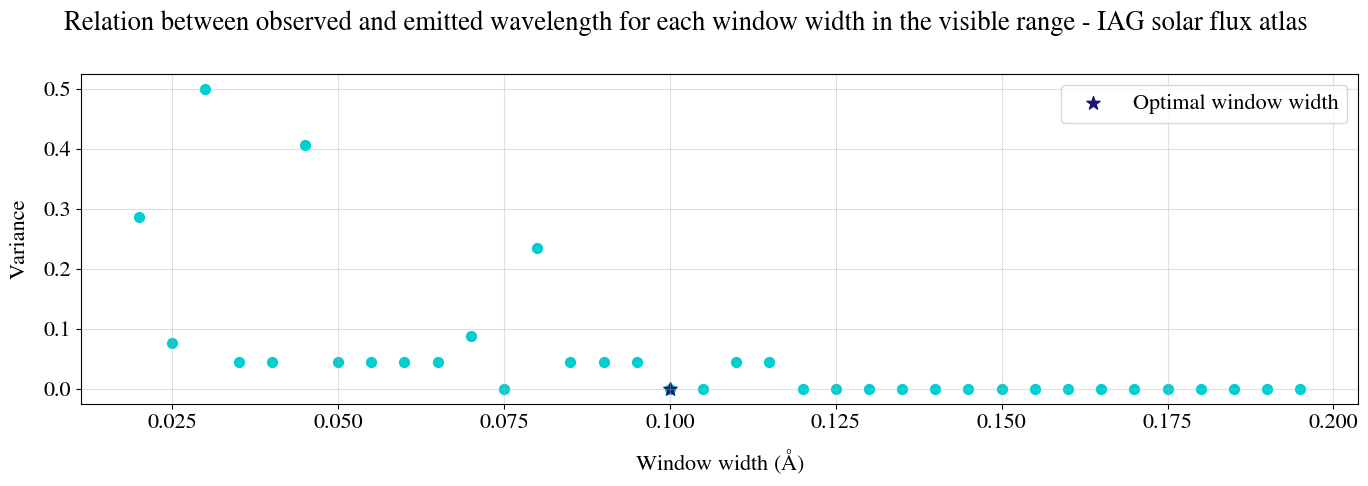

In [21]:
fig5, ax = plt.subplots(1,1,figsize=(14,5))
fig5.suptitle('Relation between observed and emitted wavelength for each window width in the visible range - IAG solar flux atlas')

ax.scatter(steps,deviation_VIS_waves,c='darkturquoise',s=50) 
ax.scatter(0.1,deviation_VIS_waves[16],c='midnightblue',marker='*',s=100,label='Optimal window width')
ax.set_ylabel(r'Variance',labelpad=10)
ax.set_xlabel(r'Window width $(\mathrm{\AA})$',labelpad=10)
ax.grid(alpha=0.4)
ax.legend()

fig5.tight_layout()
# fig5.savefig('optimal window VIS')

In [31]:
deviation_VIS_waves[16]

0.002901063046344272

### Near infrared range

In [22]:
steps = np.arange(0.02,0.2,0.005)
local_points_NIR,steps_NIR = width_minimums(closer_lines_NIR,raw_data_NIR,steps)

In [23]:
len(local_points_NIR)

247

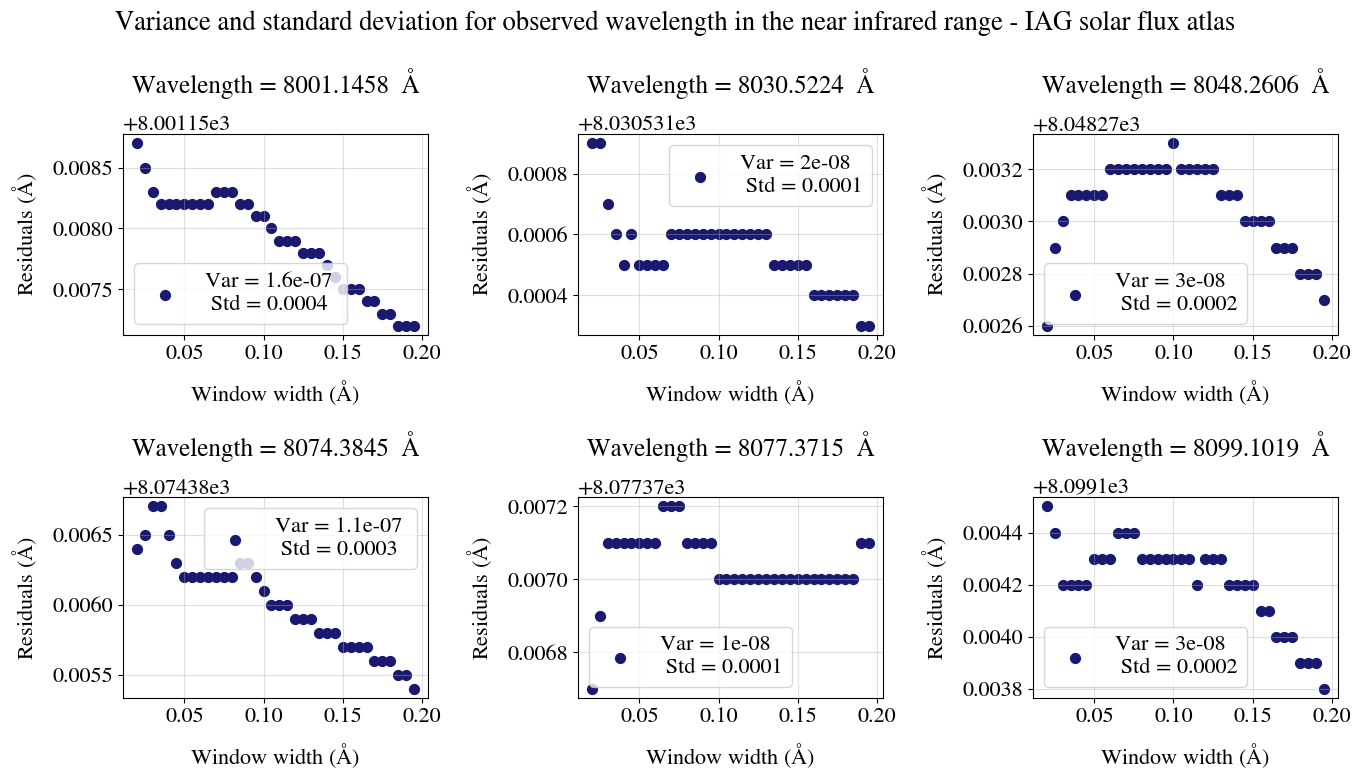

In [24]:
list_index = [0,12,35,92,120,245]

fig5, axes = plt.subplots(2,3,figsize=(14,8))
fig5.suptitle('Variance and standard deviation for observed wavelength in the near infrared range - IAG solar flux atlas')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
    Values,variance, deviation = Fit_derivates(local_points_NIR[i],closer_lines_NIR['Fe line'].iloc[i],steps_NIR[i])
    Values = Values[Values['Velocity'].between(-700,700)]
    ax.scatter(Values['Window (A)'],Values["Observed wavelength"],label = 'Var = {} \n Std = {}'.format(round(variance,8),round(deviation,4)),c='midnightblue',s=50) 

    ax.set_title(r'Wavelength = {}  Å'.format(Values["Emitted wavelength"].iloc[0]),pad=30)   
    ax.set_ylabel(r'Residuals $(\mathrm{\AA})$',labelpad=10)
    ax.set_xlabel(r'Window width $(\mathrm{\AA})$',labelpad=10)
    ax.grid(alpha=0.4)
    ax.legend()

fig5.tight_layout()
# fig5.savefig('variance std NIR')

In [25]:
#We selected bins for the width to see the slope for a lineal fit
Big_Data_NIR = []

for i in range(len(closer_lines_NIR)):
    Values,_,_ = Fit_derivates(local_points_NIR[i],closer_lines_NIR['Fe line'].iloc[i],steps_NIR[i])
    Big_Data_NIR.append(Values)

Data_NIR = pd.concat(Big_Data_NIR,axis=0)

C:\tools\Manim\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


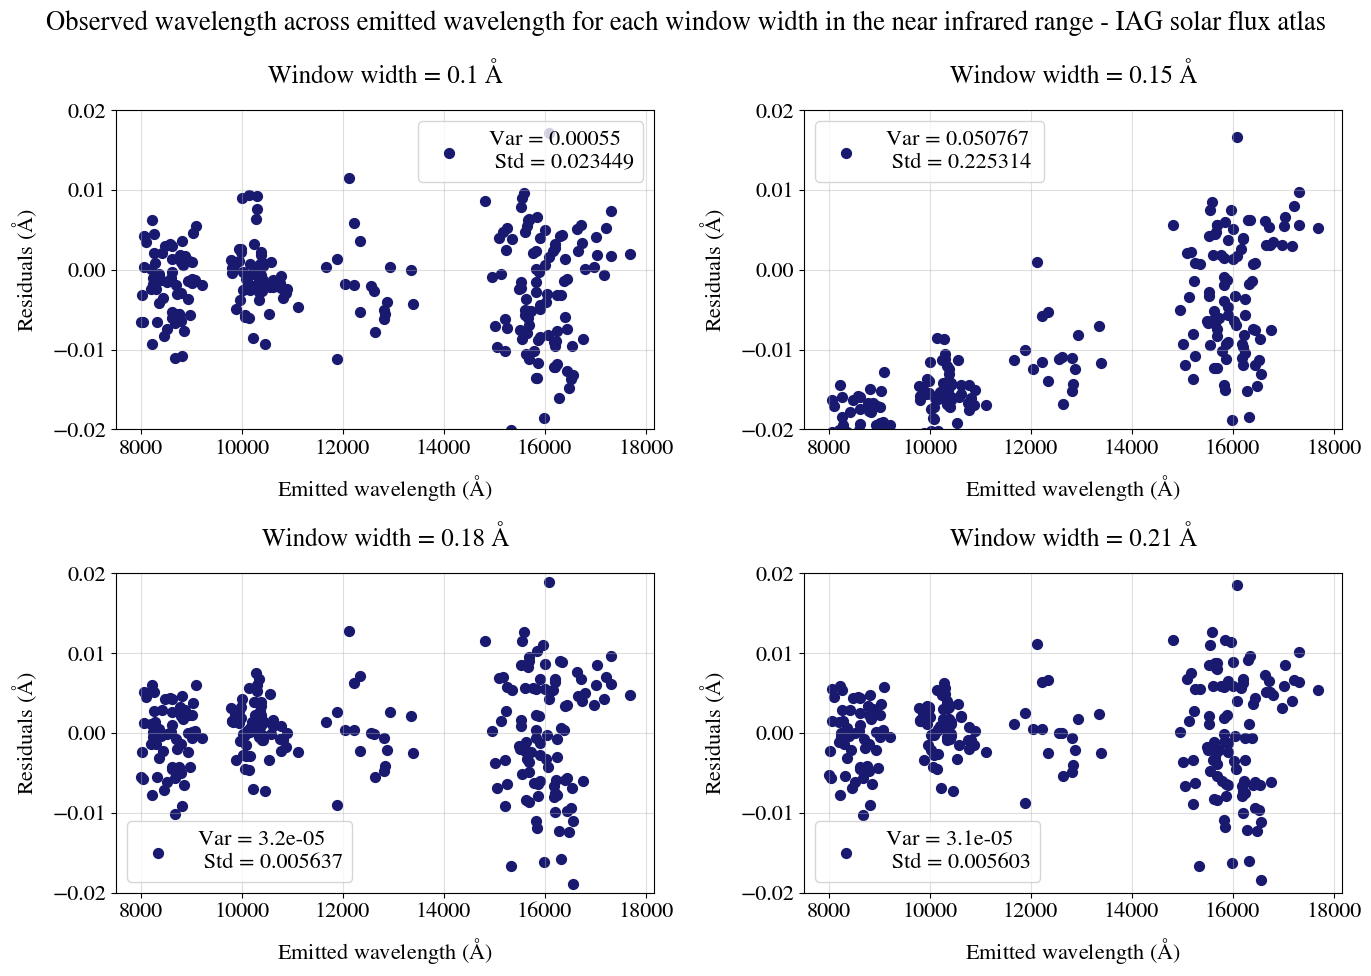

In [26]:
list_index = [6,11,14,17]

fig5, axes = plt.subplots(2,2,figsize=(14,10))
fig5.suptitle('Observed wavelength across emitted wavelength for each window width in the near infrared range - IAG solar flux atlas')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):
    new_data = Data_NIR[Data_NIR['Window (A)']==round(steps[list_index[i]],3)].sort_values(by='Emitted wavelength',ascending=True).reset_index(drop=True)
    
    #Data parameters
    param, cov = np.polyfit(new_data['Emitted wavelength'],new_data['Observed wavelength'], 1,cov=True)
    fit = np.polyval(param,new_data['Emitted wavelength'])
    error = np.sqrt(np.diag(cov))

    residuals = fit-new_data['Observed wavelength'] 
    ax.scatter(new_data['Emitted wavelength'],residuals,c='midnightblue',s=50,label='Var = {} \n Std = {}'.format(round(np.var(residuals),6),round(np.std(residuals),6))) 

    ax.set_title('Window width = {} Å'.format(round(steps[list_index[i]]*2,4)),pad=20)   
    ax.set_ylabel(r'Residuals $(\mathrm{\AA})$',labelpad=10)
    ax.set_xlabel(r'Emitted wavelength $(\mathrm{\AA})$',labelpad=10)
    ax.grid(alpha=0.4)
    ax.set_ylim(-0.02,0.02)
    ax.legend()

fig5.tight_layout()
# fig5.savefig('variance slopes NIR')

In [35]:
variance_NIR_waves = []
deviation_NIR_waves = []

for each in steps:
    new_data = Data_NIR[Data_NIR['Window (A)']==round(each,3)].sort_values(by='Emitted wavelength',ascending=True).reset_index(drop=True)

    param = np.polyfit(new_data['Emitted wavelength'],new_data['Observed wavelength'], 1)
    fit = np.polyval(param,new_data['Emitted wavelength'])
    residuals = fit-new_data['Observed wavelength'] 
        
    variance_NIR_waves.append(np.var(residuals.between(-0.02,0.02)))
    deviation_NIR_waves.append(np.std(residuals.between(-0.02,0.02)))

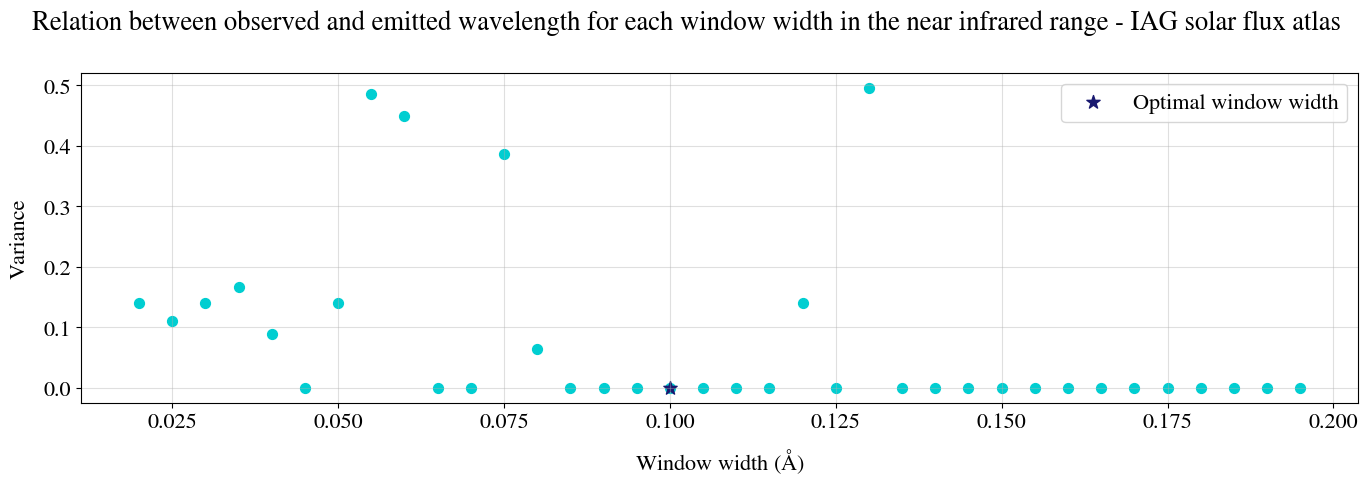

In [28]:
fig5, ax = plt.subplots(1,1,figsize=(14,5))
fig5.suptitle('Relation between observed and emitted wavelength for each window width in the near infrared range - IAG solar flux atlas')

ax.scatter(steps,deviation_NIR_waves,c='darkturquoise',s=50) 
ax.scatter(0.1,deviation_NIR_waves[16],c='midnightblue',marker='*',s=100,label='Optimal window width')

ax.set_ylabel(r'Variance',labelpad=10)
ax.set_xlabel(r'Window width $(\mathrm{\AA})$',labelpad=10)
ax.grid(alpha=0.4)
ax.legend()

fig5.tight_layout()
# fig5.savefig('optimal window NIR')